# Trích xuất đặc trưng dựa trên Word2vec

In [1]:
import pandas as pd


## 1. Tải dữ liệu đã tiền xử lý 

In [2]:
#loading the phishing URLs data to dataframe
data0 = pd.read_csv('/Users/HP/projectML/email_pre_processed.csv')
data0.head()

,text,spam
0,subject naturally irresistible corporate ident...,1
1,subject stock trading gunslinger fanny merrill...,1
2,subject unbelievable new home made easy im wan...,1
3,subject color printing special request additio...,1
4,subject money get software cd software compati...,1


# 2. Sử dụng Word2vec

## 2.1 Tokenizing 

In [3]:
x_tokenized = [[w for w in sentence.split(" ") if w != ""] for sentence in data0['text']]
x_tokenized[0]

['subject',
 'naturally',
 'irresistible',
 'corporate',
 'identity',
 'lt',
 'really',
 'hard',
 'recollect',
 'company',
 'market',
 'full',
 'suqgestions',
 'information',
 'isoverwhelminq',
 'good',
 'catchy',
 'logo',
 'stylish',
 'statlonery',
 'outstanding',
 'website',
 'make',
 'task',
 'much',
 'easier',
 'promise',
 'havinq',
 'ordered',
 'iogo',
 'company',
 'automaticaily',
 'become',
 'world',
 'ieader',
 'isguite',
 'ciear',
 'without',
 'good',
 'product',
 'effective',
 'business',
 'organization',
 'practicable',
 'aim',
 'hotat',
 'nowadays',
 'market',
 'promise',
 'marketing',
 'effort',
 'become',
 'much',
 'effective',
 'list',
 'clear',
 'benefit',
 'creativeness',
 'hand',
 'made',
 'original',
 'logo',
 'specially',
 'done',
 'reflect',
 'distinctive',
 'company',
 'image',
 'convenience',
 'logo',
 'stationery',
 'provided',
 'format',
 'easy',
 'use',
 'content',
 'management',
 'system',
 'letsyou',
 'change',
 'website',
 'content',
 'even',
 'structure',


## 2.2 Khởi tạo model Word2vec

In [34]:
import gensim
from gensim.models import Word2Vec


model = gensim.models.Word2Vec(x_tokenized,
                 vector_size=100
                 # Size is the length of our vector.
                )



In [35]:
model.wv.most_similar("free")

[('secure', 0.7830626368522644),
 ('ad', 0.7568588852882385),
 ('feel', 0.7416977286338806),
 ('quote', 0.7358649969100952),
 ('downloads', 0.7191898822784424),
 ('online', 0.7168831825256348),
 ('anywhere', 0.6862483620643616),
 ('classified', 0.6829990148544312),
 ('otherwise', 0.6825507879257202),
 ('risknews', 0.6783303022384644)]

## 2.3 Lớp tạo chuỗi word embedding

In [6]:
class Sequencer():
    
    def __init__(self,
                 all_words,
                 max_words,
                 seq_len,
                 embedding_matrix
                ):
        
        self.seq_len = seq_len
        self.embed_matrix = embedding_matrix
        """
        temp_vocab = Vocab which has all the unique words
        self.vocab = Our last vocab which has only most used N words.
    
        """
        temp_vocab = list(set(all_words))
        self.vocab = []
        self.word_cnts = {}
        """
        Now we'll create a hash map (dict) which includes words and their occurencies
        """
        for word in temp_vocab:
            # 0 does not have a meaning, you can add the word to the list
            # or something different.
            count = len([0 for w in all_words if w == word])
            self.word_cnts[word] = count
            counts = list(self.word_cnts.values())
            indexes = list(range(len(counts)))
        
        # Now we'll sort counts and while sorting them also will sort indexes.
        # We'll use those indexes to find most used N word.
        cnt = 0
        while cnt + 1 != len(counts):
            cnt = 0
            for i in range(len(counts)-1):
                if counts[i] < counts[i+1]:
                    counts[i+1],counts[i] = counts[i],counts[i+1]
                    indexes[i],indexes[i+1] = indexes[i+1],indexes[i]
                else:
                    cnt += 1
        
        for ind in indexes[:max_words]:
            self.vocab.append(temp_vocab[ind])
                    
    def textToVector(self,text):
        # First we need to split the text into its tokens and learn the length
        # If length is shorter than the max len we'll add some spaces (100D vectors which has only zero values)
        # If it's longer than the max len we'll trim from the end.
        tokens = text.split()
        len_v = len(tokens)-1 if len(tokens) < self.seq_len else self.seq_len-1
        vec = []
        for tok in tokens[:len_v]:
            try:
                vec.append(self.embed_matrix[tok])
            except Exception as E:
                pass
        
        last_pieces = self.seq_len - len(vec)
        for i in range(last_pieces):
            vec.append(np.zeros(100,))
        
        return np.asarray(vec).flatten()


In [7]:
sequencer = Sequencer(all_words = [token for seq in x_tokenized for token in seq],
              max_words = 1200,
              seq_len = 14,
              embedding_matrix = model.wv
             )

In [167]:
import numpy as np
test_vec = sequencer.textToVector("i am in love with you hihi")
test_vec

array([0.14387274, 0.19471148, 0.14099523, ..., 0.        , 0.        ,
       0.        ])

In [10]:
# But before creating a PCA model using scikit-learn let's create
# vectors for our each vector
x_vecs = np.asarray([sequencer.textToVector(" ".join(seq)) for seq in x_tokenized])
print(x_vecs.shape)

(5728, 1400)


## 2.4 Giảm chiều vector sử dụng PCA  

In [195]:
from sklearn.decomposition import PCA
#pca_model = PCA(n_components=300)
pca_model = PCA()
pca_model.fit(x_vecs)
print("Sum of variance ratios: ",sum(pca_model.explained_variance_ratio_))

Sum of variance ratios:  1.0000000000000002


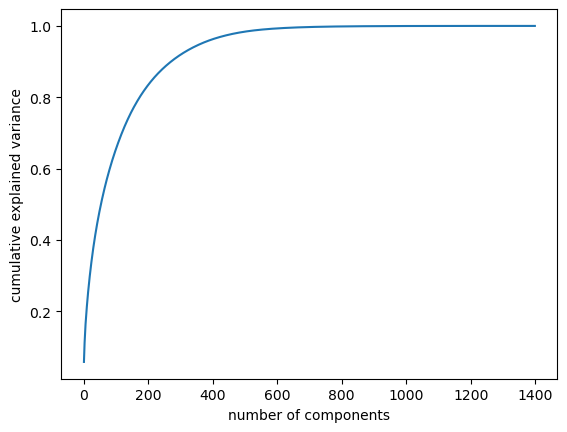

In [196]:
#Choose components satisfy 90-95% of variance
import pylab as plt
import numpy as np 
plt.plot(np.cumsum(pca_model.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [145]:
x_comps = pca_model.transform(x_vecs)
x_comps.shape

(5728, 300)

## 3. Chia dataset thành train set và test set 

In [146]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_comps,data0['spam'],test_size=0.2,random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4582, 300)
(1146, 300)
(4582,)
(1146,)


## 4. Chuẩn hóa miền giá trị sau khi sử dụng Word2vec 

In [147]:
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()
# print(scaler.fit(x_test_transformed))
print(scaler.fit(np.concatenate((x_train,x_test))))

print(scaler.data_max_)
print(scaler.transform(x_train))
print(scaler.transform(x_test))
X_train_W2vec=scaler.transform(x_train)
X_test_W2vec=scaler.transform(x_test)

MinMaxScaler()
[26.74965329 14.75343286 16.14579545 13.71163517 13.18348436 12.94184961
 12.12277883 10.62316688 12.50624698  9.23044256 10.58646466 10.07029002
  9.78974637 10.70709994  9.6142837  10.35061826  9.5138904   9.84288622
  9.46770501  8.22961096  8.46818362  8.3028419   8.64447169  8.24991541
  9.0325908  10.49381713  8.99322671  8.2217966   8.71155636  8.04544384
  8.1876525   7.86142787  9.50234319  7.99966207  7.53777854  7.32219166
  7.35812645  6.56073927  7.45525959  8.55991995  7.02376279  7.43202871
  7.74301356  7.4391051   6.92879348  6.42260999  6.46114681  8.02950551
  7.78954006  6.95721752  7.13421325  6.85513241  7.22172345  7.66983036
  8.05437879  6.73787312  7.73731424  7.4649106   9.3396678   7.48472967
  6.7974797   7.46707708  6.463725    7.10374542  6.16763776  6.32763861
  5.9399141   6.60289662  5.81228409  6.43999874  5.68808342  5.80018657
  6.19971914  5.37700977  5.87227643  5.67114727  5.9388668   6.49588886
  5.5646879   6.12729274  6.26877513

## 5. Huấn luyện mô hình 

## 5.1 SVM 

Đây là bước tinh chỉnh các siêu tham số cho mô hình

In [148]:
from sklearn import svm
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
"""
param_grid_SVM = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']}


gs_svm = GridSearchCV(SVC(),param_grid_SVM,cv=5) 
gs_svm.fit(X_train_W2vec,y_train)
"""

"\nparam_grid_SVM = {'C': [0.1, 1, 10, 100, 1000],\n              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],\n              'kernel': ['rbf','linear']}\n\n\ngs_svm = GridSearchCV(SVC(),param_grid_SVM,cv=5) \ngs_svm.fit(X_train_W2vec,y_train)\n"

In [149]:
# gs_svm.best_params_

In [150]:
#gs_svm.best_score_

Sử dụng tham số tối ưu đã tìm được vào mô hình học

In [151]:
from sklearn.svm import SVC
#Create a svm Classifier

clf = svm.SVC(C=10, gamma=0.1,kernel='rbf') 

#Train the model using the training sets
clf.fit(X_train_W2vec,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_W2vec)


In [152]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: ', format(accuracy_score(y_pred,y_test)))
print('Precision score: ', format(precision_score(y_pred,y_test)))
print('Recall score: ', format(recall_score(y_pred,y_test)))
print('F1 score: ', format(f1_score(y_pred,y_test))) 

Accuracy score:  0.9284467713787086
Precision score:  0.8379310344827586
Recall score:  0.8741007194244604
F1 score:  0.8556338028169015


In [153]:
print(np.amin(X_train_W2vec))
print(np.amax(X_train_W2vec))

0.0
1.0000000000000002


## 5.2 Naive Bayes

In [154]:
from sklearn.naive_bayes import GaussianNB
naive_bayes = GaussianNB()
naive_bayes.fit(X_train_W2vec,y_train)
predictions = naive_bayes.predict(X_test_W2vec)
predictions

array([0, 1, 0, ..., 1, 1, 0], dtype=int64)

In [155]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: ', format(accuracy_score(predictions,y_test)))
print('Precision score: ', format(precision_score(predictions,y_test)))
print('Recall score: ', format(recall_score(predictions,y_test)))
print('F1 score: ', format(f1_score(predictions,y_test)))

Accuracy score:  0.7181500872600349
Precision score:  0.6827586206896552
Recall score:  0.46153846153846156
F1 score:  0.5507649513212797


## 5.3 KNN 

Đây là bước tinh chỉnh các siêu tham số cho mô hình

In [156]:
from sklearn.neighbors import KNeighborsClassifier
"""
param_grid = {'n_neighbors': list(range(1,9)),'weights' : ['uniform','distance'],'metric' : ['minkowski','euclidean','manhattan'] }
gs_knn = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5)
gs_knn.fit(X_train_W2vec,y_train)
"""

"\nparam_grid = {'n_neighbors': list(range(1,9)),'weights' : ['uniform','distance'],'metric' : ['minkowski','euclidean','manhattan'] }\ngs_knn = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5)\ngs_knn.fit(X_train_W2vec,y_train)\n"

In [157]:
# gs_knn.best_score_

In [158]:
# gs_knn.best_params_

Sử dụng tham số tối ưu đã tìm được vào mô hình học

In [159]:
knn = KNeighborsClassifier(n_neighbors = 2, weights = 'uniform',metric = 'minkowski')
knn.fit(X_train_W2vec,y_train) 
y_pred_knn = knn.predict(X_test_W2vec) 

In [160]:
print('Accuracy score: ', format(accuracy_score(y_pred_knn,y_test)))
print('Precision score: ', format(precision_score(y_pred_knn,y_test)))
print('Recall score: ', format(recall_score(y_pred_knn,y_test)))
print('F1 score: ', format(f1_score(y_pred_knn,y_test))) 

Accuracy score:  0.7931937172774869
Precision score:  0.7448275862068966
Recall score:  0.5699208443271768
F1 score:  0.6457399103139013


## 5.4 Random forest 

Đây là bước tinh chỉnh các siêu tham số cho mô hình

In [161]:
from sklearn.ensemble import RandomForestClassifier
"""
param_grid_RF = {'n_estimators': [25, 50, 100, 150],'max_features': ['sqrt', 'log2', None],'max_depth': [3, 6, 9],'max_leaf_nodes': [3, 6, 9],}
gs_rf = GridSearchCV(RandomForestClassifier(),param_grid_RF,cv=5)
gs_rf.fit(X_train_W2vec,y_train)
""" 

"\nparam_grid_RF = {'n_estimators': [25, 50, 100, 150],'max_features': ['sqrt', 'log2', None],'max_depth': [3, 6, 9],'max_leaf_nodes': [3, 6, 9],}\ngs_rf = GridSearchCV(RandomForestClassifier(),param_grid_RF,cv=5)\ngs_rf.fit(X_train_W2vec,y_train)\n"

In [162]:
# gs_rf.best_score_

In [163]:
# gs_rf.best_params_

Sử dụng tham số tối ưu đã tìm được vào mô hình học

In [164]:
rf = RandomForestClassifier(n_estimators=100,max_depth=6,max_leaf_nodes=9,max_features=None,n_jobs=-1)
rf_model = rf.fit(X_train_W2vec,y_train)
y_pred_rf=rf_model.predict(X_test_W2vec)

In [165]:
print('Accuracy score: ', format(accuracy_score(y_pred_rf,y_test))) 
print('Precision score: ', format(precision_score(y_pred_rf,y_test)))
print('Recall score: ', format(recall_score(y_pred_rf,y_test)))
print('F1 score: ', format(f1_score(y_pred_rf,y_test))) 

Accuracy score:  0.8830715532286213
Precision score:  0.6931034482758621
Recall score:  0.8170731707317073
F1 score:  0.75


In [186]:
import matplotlib.pyplot as plt

x_labels = ["SVM", "Naive Bayes", "k-NN", "Random Forest"]
accuracy_scores = [accuracy_score(y_pred,y_test), accuracy_score(predictions,y_test), accuracy_score(y_pred_knn,y_test), accuracy_score(y_pred_rf,y_test)]
precision_scores = [precision_score(y_pred,y_test), precision_score(predictions,y_test), precision_score(y_pred_knn,y_test), precision_score(y_pred_rf,y_test)]
recall_scores = [recall_score(y_pred,y_test), recall_score(predictions,y_test), recall_score(y_pred_knn,y_test), recall_score(y_pred_rf,y_test)]
f1_scores = [f1_score(y_pred,y_test), f1_score(predictions,y_test), f1_score(y_pred_knn,y_test), f1_score(y_pred_rf,y_test)]

(0.0, 1.0)

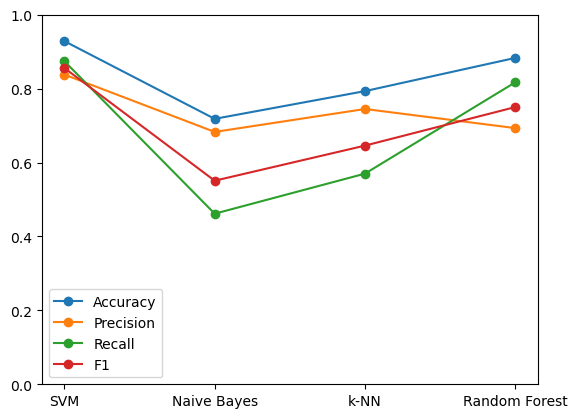

In [187]:
plt.plot(x_labels, accuracy_scores, marker = 'o')
plt.plot(x_labels, precision_scores, marker = 'o')
plt.plot(x_labels, recall_scores, marker = 'o')
plt.plot(x_labels, f1_scores, marker = 'o')
plt.legend(['Accuracy', 'Precision', 'Recall', 'F1'])
plt.ylim([0,1])

(0.0, 1.0)

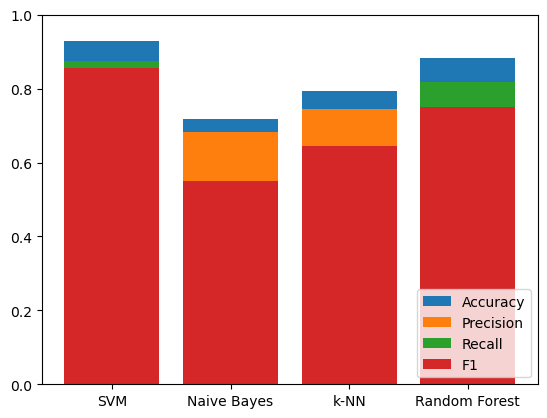

In [194]:
plt.bar(x_labels, accuracy_scores)
plt.bar(x_labels, precision_scores)
plt.bar(x_labels, recall_scores)
plt.bar(x_labels, f1_scores)
plt.legend(['Accuracy', 'Precision', 'Recall', 'F1'], loc=4)
plt.ylim([0,1])